### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format='retina'

# 2-d Scatter Plot

(1000, 3)


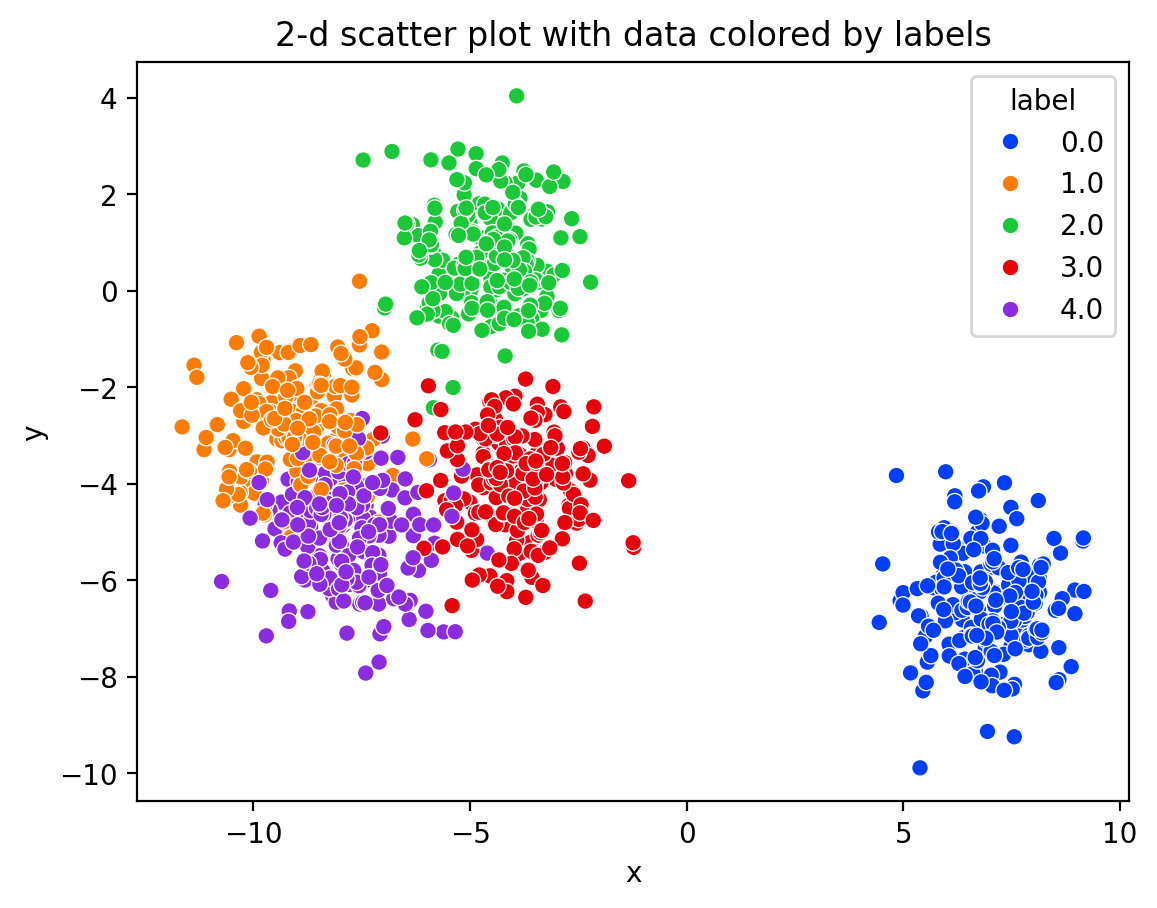

In [41]:
data = np.load('hw_data/hw6_data_1.npy')
print(data.shape)
x= data[:,0]
y=data[:,1]
df = pd.DataFrame(data,columns=['x','y','label'])
sns.scatterplot(data=df, x='x', y='y', hue='label',palette='bright')
plt.title("2-d scatter plot with data colored by labels")
plt.show()


# Kernel Density Estimation

0.4724137931034482


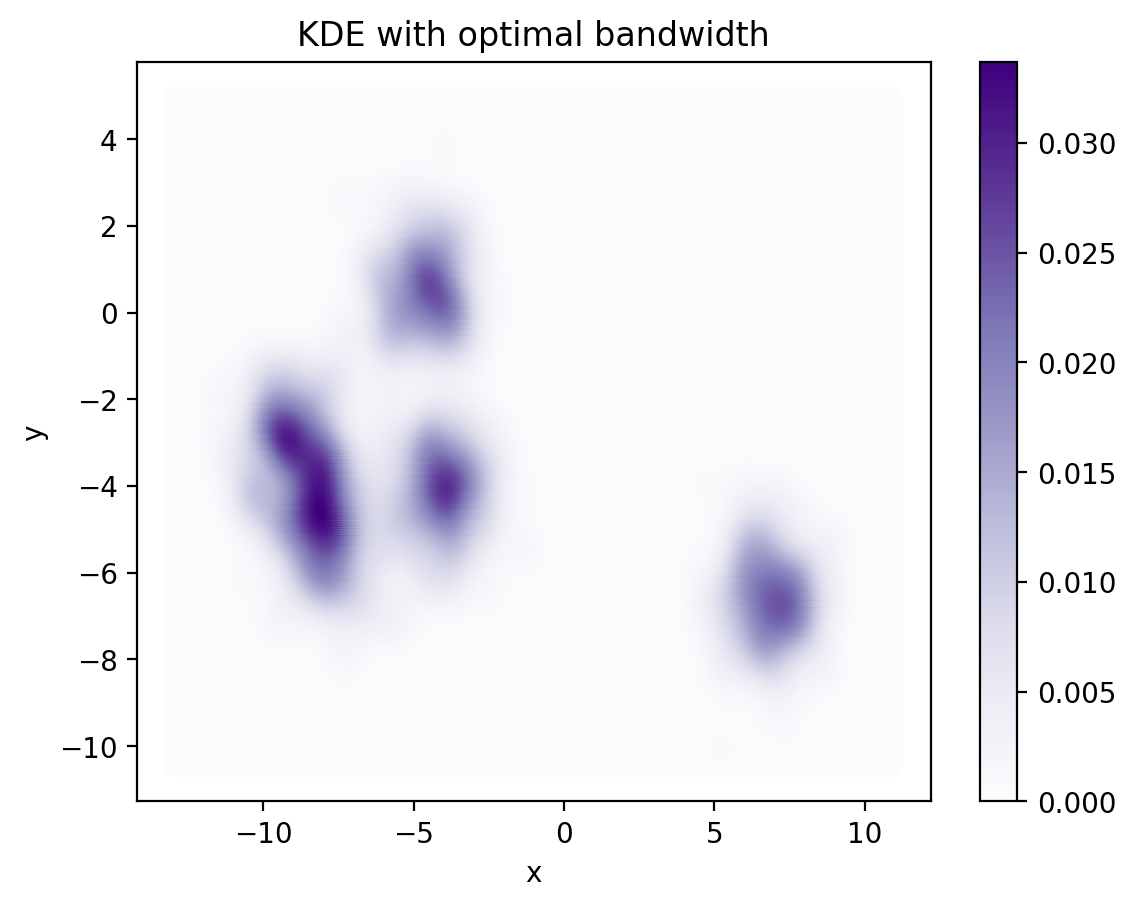

In [89]:
# Complete and Execute this cell to determine the bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

X = data[:,0:2] # Make combined array
bwrange = np.linspace(0.1,1.0,30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth':bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(X) #Fit the combined array
h_opt = grid.best_params_['bandwidth'] # Find the best fit 
print(h_opt)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = np.linspace(-13,11,300)
v = np.linspace(-10.5,5,300)

Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.title("KDE with optimal bandwidth")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Nearest Neighbors Approach


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


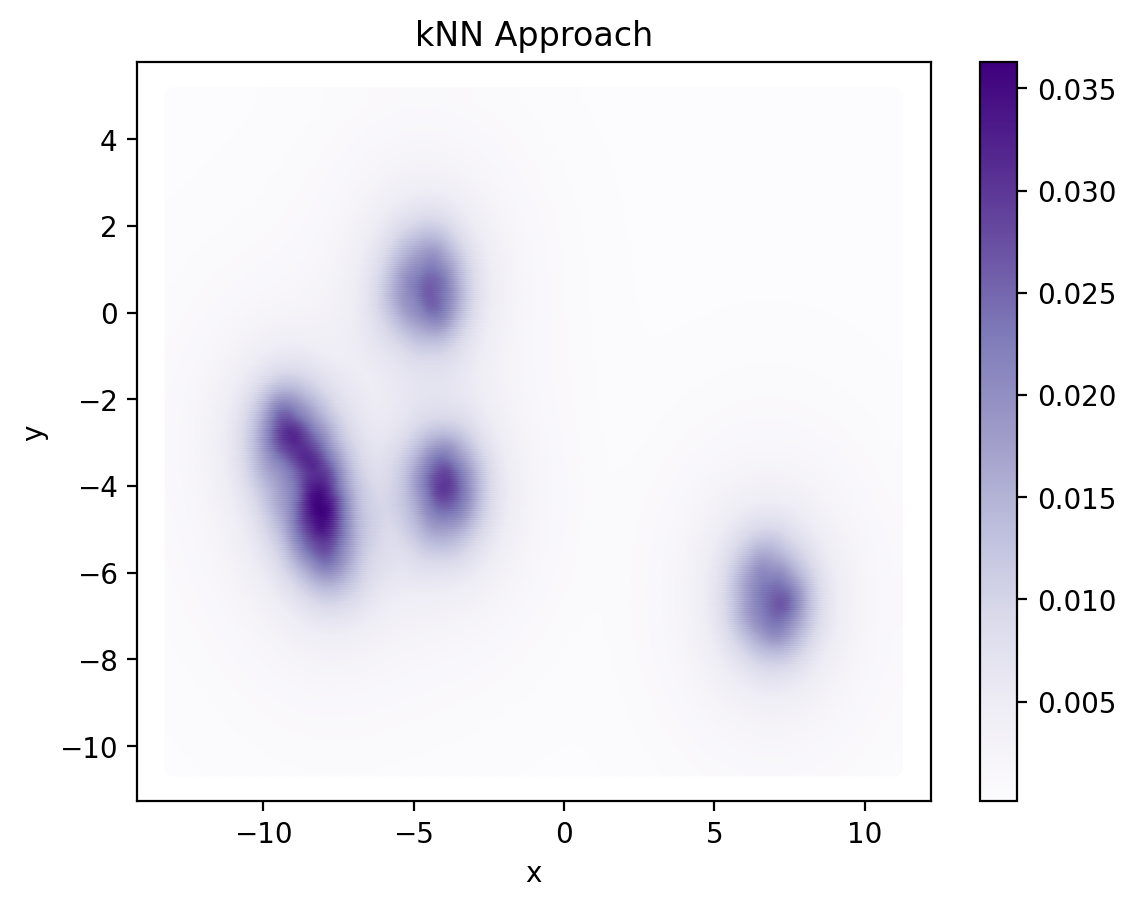

In [96]:
# Compute density with Bayesian nearest neighbors

from astroML.density_estimation import KNeighborsDensity
from sklearn.neighbors import KernelDensity

k  = 90 # this value of k gave a similar plot as KDE distribution, but how do we test it
N = len(data)
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.title("kNN Approach")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Gaussian mixture model

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

For BIC, the optimal number of components is 4 as BIC is minimum at 4 and constant after that.


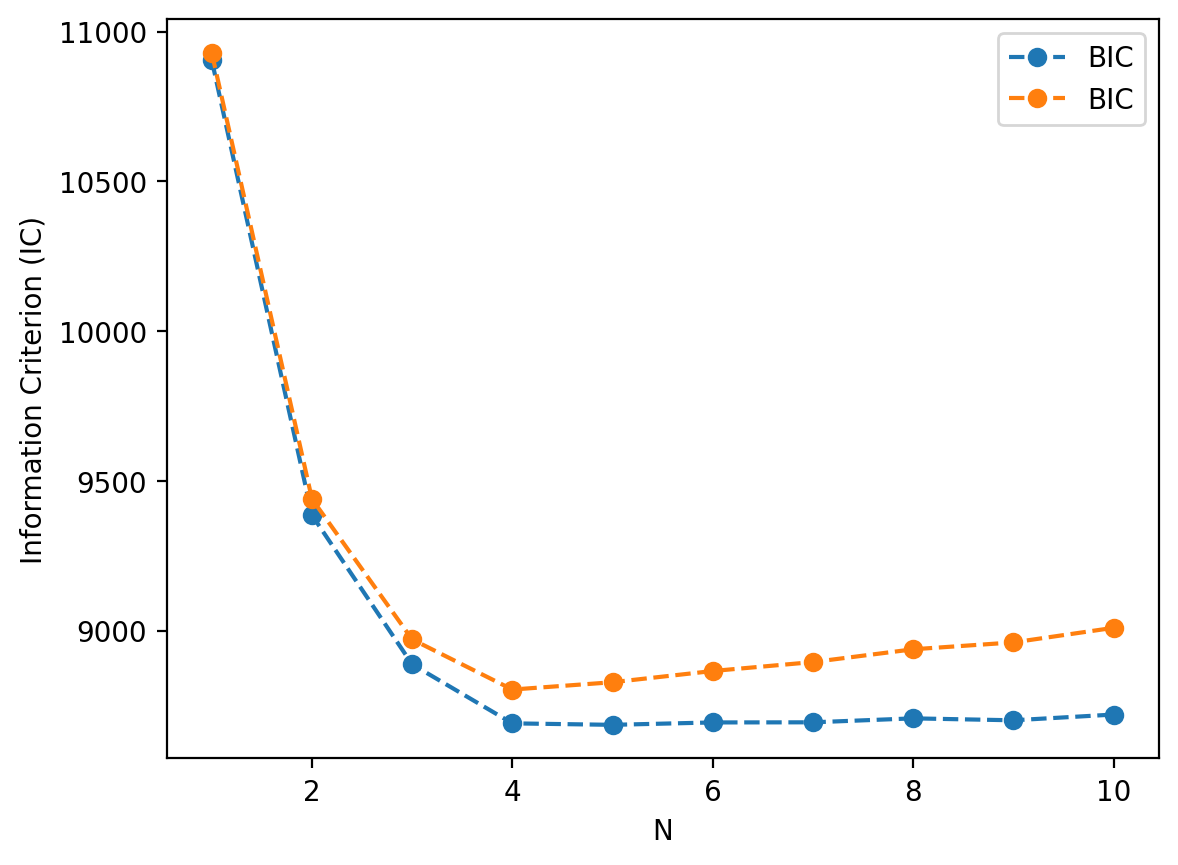

In [103]:
from sklearn.mixture import GaussianMixture

N = np.arange(1, 11) # number of GMM components between 1 and 10
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

plt.plot(N,AIC,marker='o',ls='--',label="AIC")
plt.plot(N,BIC,marker='o',ls='--',label="BIC")
plt.legend()
plt.xlabel("N")
plt.ylabel("Information Criterion (IC)")
print("For BIC, the optimal number of components is 4 as BIC is minimum at 4 and constant after that.")
plt.show()


In [ ]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))



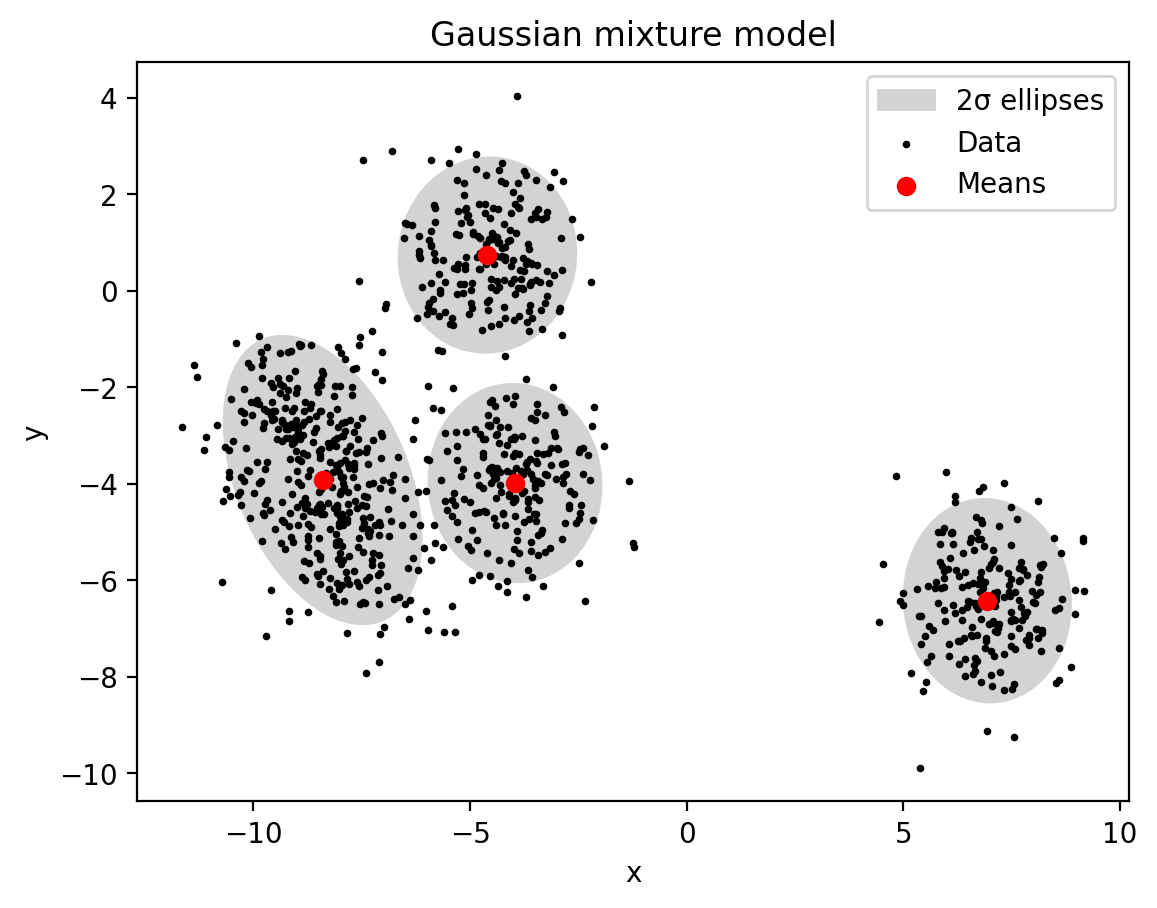

In [158]:
opt_n = 4
opt_model = GaussianMixture(opt_n).fit(X)
mu_vals = opt_model.means_ # get the means (for x and y) of length(data) from the optimal model
C_vals  = opt_model.covariances_

# Plot the 2-sigma ellipses
for i in range(len(mu_vals)):
    mu = mu_vals[i]
    C  = C_vals[i]
    if i ==0: # To Label only once
        draw_ellipse(mu, C, scales=[2], ax=None,color='lightgrey',label="2σ ellipses") # scales = 2sigma only. 
    else:
        draw_ellipse(mu, C, scales=[2], ax=None,color='lightgrey') # scales = 2sigma only

# Plot the data
plt.scatter(x,y,s=3,c='black',label='Data') 

#Plot the means
plt.scatter(mu_vals[:,0],mu_vals[:,1],c='red',label='Means')


# Let's get the ellipses


plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Gaussian mixture model")
plt.show()

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

# Kmeans Clustering

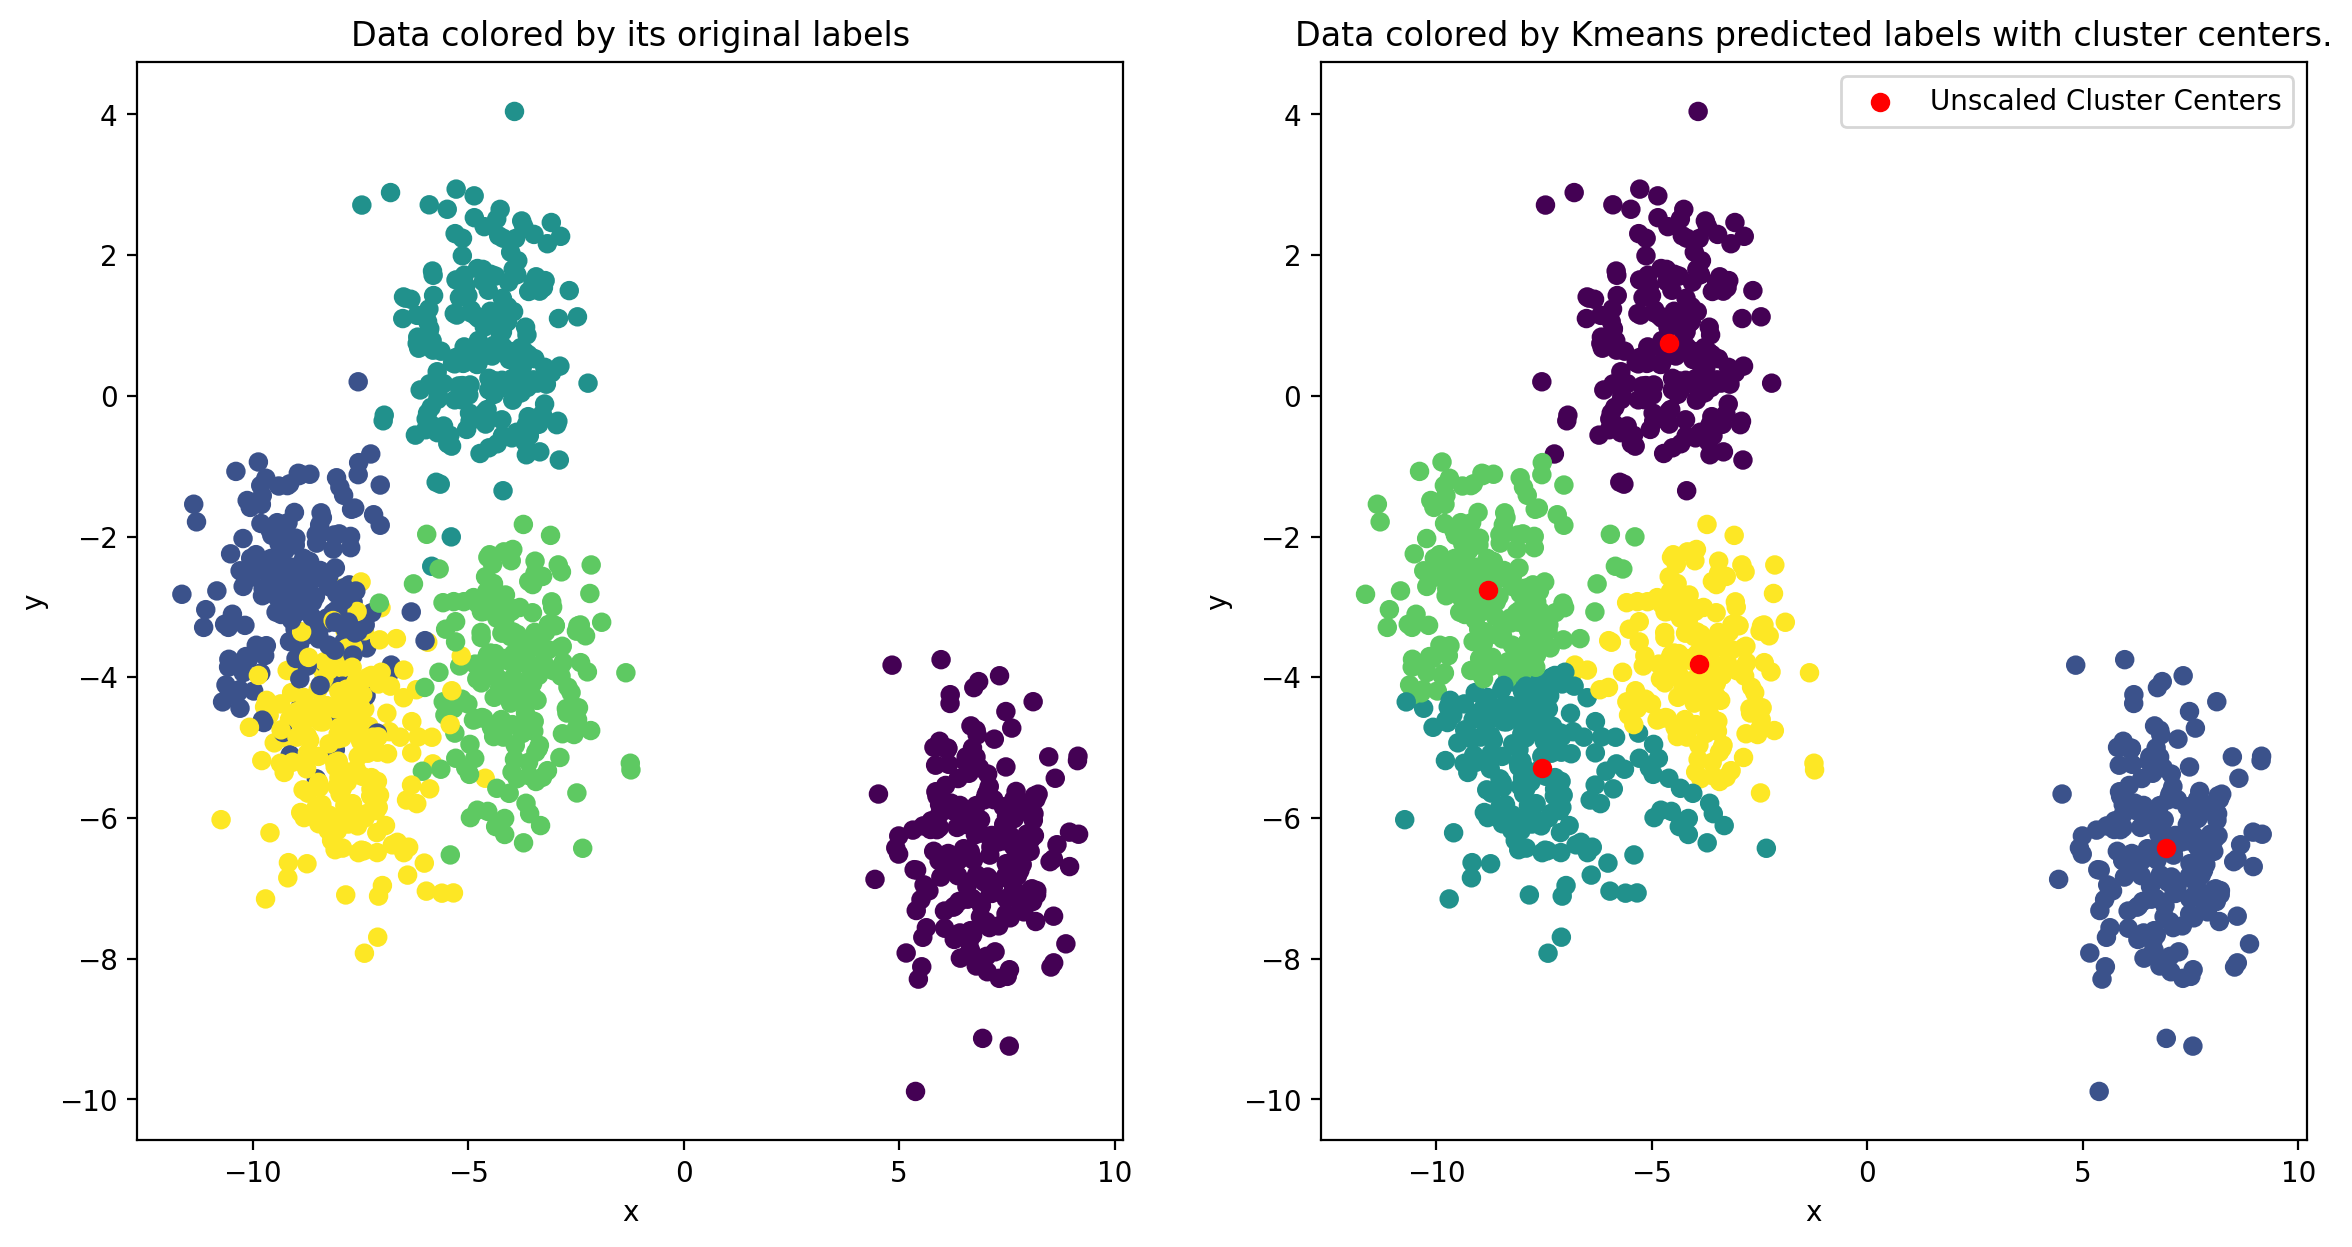

In [207]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

scaled_centers = clf.cluster_centers_ #location of the clusters
unscaled_centers = scaler.inverse_transform(scaled_centers)
labels = clf.predict(scaler.transform(X)) #labels for each of the points

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.scatter(x,y,c=data[:,2],cmap='viridis')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Data colored by its original labels")


ax2.scatter(x,y,c=labels,cmap='viridis') # Predicted Labels
ax2.scatter(unscaled_centers[:,0],unscaled_centers[:,1],c='red',label="Unscaled Cluster Centers") # Cluster centers
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Data colored by Kmeans predicted labels with cluster centers.")

             
plt.legend()
plt.show()

<span style="color:green"> NP: Correct! Good job! </span>